# Working with Classiq and logical qubits

As explained by Professor John Preskill (https://www.youtube.com/watch?v=uwBv6piN-9s), the quantum computing community increasingly recognizes it needs fault-tolerant quantum computers, implementing quantum error correction. This will give birth to a new type of qubit: logical qubits.

Logical qubits are error-corrected qubits, made out of several physical qubits working together to fix each other's errors. As an algorithm designer, it should matter little to you how these logical qubits are built (although you can learn more about it at https://journals.aps.org/prx/abstract/10.1103/PhysRevX.9.041053 for example). You will however care about how they behave and you will need to adapt your algorithms accordingly. This notebook offers you a glimpse at what this experience will look like.

Two main things in particular will require your attention:
* Transpilation, because logical qubits use a specific, discrete gate set
* Error rates, because logical qubits aren't error-free

The first part of this notebook will show you how to study the impact of transpilation to logical qubits in terms of circuit depth and accuracy, and how to find optimal transpilation parameters.

The second part of this notebook will show you how to study the impact of noise on the quality of your algorithm's results, and how it depends on the logical qubit's parameters.

In this notebook, we'll be using Alice & Bob's logical qubit emulator. While some parameters are specific to Alice & Bob's cat qubits, most of the principles we'll use also apply to other architectures.

### Helpers

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

from classiq import *
from classiq.execution import *
from classiq.interface.backend.quantum_backend_providers import (
    AliceBobBackendNames,
    ProviderVendor,
)
from classiq.synthesis import set_preferences

## First Part: Targeting the Logical Qubits' Gate Set

The native gates for a logical architecture are discrete, i.e. they do not take parameters like a rotation angle. Most architectures rely on the "Clifford + T" gate set, i.e. gates generating the [Clifford group](https://en.wikipedia.org/wiki/Clifford_group) and the [T gate](https://en.wikipedia.org/wiki/Quantum_logic_gate#Phase_shift_gates).

This gate set is said to be "universal", meaning that any gate can be approximated with arbitrary precision using a series of these gates, with the number of gates growing as the logarithm of the desired precision.

This means that if the algorithm you want to run contains rotations for example, these rotations will have to be approximated by a series of discrete gates.

Let us see a first example, using a simple 1-qubit rotation:

In [2]:
@qfunc
def main(q: Output[QBit]):
    allocate(1, q)
    RX(0.1, q)


qmod = create_model(main)
qmod = set_execution_preferences(
    qmod, execution_preferences=ExecutionPreferences(num_shots=10_000)
)
qprog = synthesize(qmod)

print("Circuit depth: %i\n" % qprog.program_circuit.depth)

show(qprog)

Circuit depth: 1

Opening: https://platform.classiq.io/circuit/2v4opr6xzmMgEnHrNKNAwAoZaJF?login=True&version=0.73.0


As you can see, because we didn't put constraints on the backend's gate set, the transpiled program only contains one gate.

But now, let's try to target an Alice & Bob backend and see what happens.

In [3]:
backend_preferences = AliceBobBackendPreferences(
    backend_service_provider=ProviderVendor.ALICE_AND_BOB,
    backend_name=AliceBobBackendNames.LOGICAL_TARGET,
)
execution_preferences = ExecutionPreferences(
    num_shots=10_000, backend_preferences=backend_preferences
)

# Prepare for HW aware synthesis
preferences = Preferences(
    backend_service_provider=ProviderVendor.ALICE_AND_BOB,
    backend_name=AliceBobBackendNames.LOGICAL_TARGET,
)

# Create Model, set settings and perform HW aware synthesis
model = create_model(main)
model = set_execution_preferences(model, execution_preferences)
model = set_preferences(model, preferences=preferences)
qprog = synthesize(model)

print("Circuit depth: %i\n" % qprog.program_circuit.depth)

show(qprog)

Circuit depth: 170

Opening: https://platform.classiq.io/circuit/2v4oqLh7s7fQYOzMCVDjmZxdwmF?login=True&version=0.73.0


Because the RX gate had to be transpiled, the circuit now has depth 170 instead of 1.

After running the `show()` command, you can check the depth of the circuit and even its detailed gate count in the Classiq GUI:

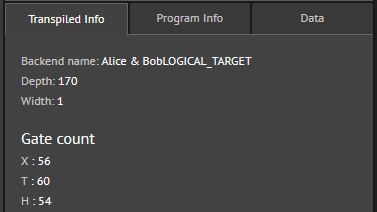

By default, the Classiq platform displays the circuit before transpilation to the logical gate set. But it is easy to display the transpiled circuit.

First, save it as "Transpiled QASM":

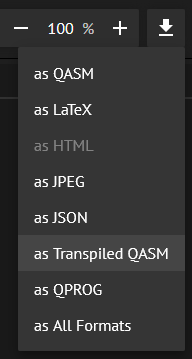

Then, upload it:

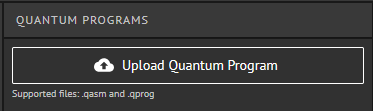

And you should see something like this:

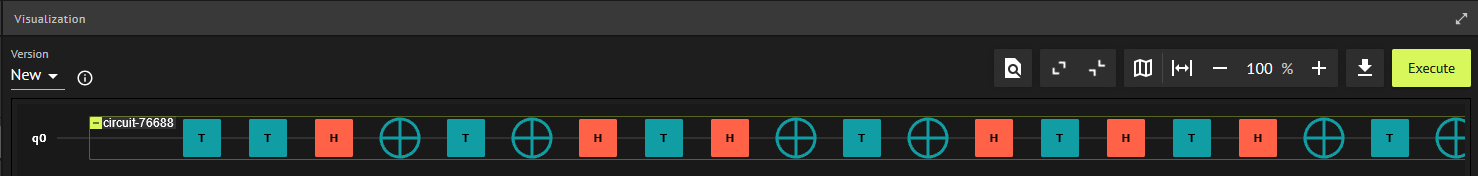

You may now explore how the circuit was transpiled to a series of X, T and H gates.

Importantly, the above is only an approximation of the rotation gate we specified (`RX(0.1)`).

What if it does not reproduce the desired gate with enough precision?

In this case, you may increase the `solovay_kitaev_max_iterations` parameter, like so:

In [4]:
# Prepare for HW aware synthesis
preferences = Preferences(
    backend_service_provider=ProviderVendor.ALICE_AND_BOB,
    backend_name=AliceBobBackendNames.LOGICAL_TARGET,
    solovay_kitaev_max_iterations=3,
)

# Create Model, set settings and perform HW aware synthesis
model = create_model(main)
model = set_execution_preferences(model, execution_preferences)
model = set_preferences(model, preferences=preferences)
qprog = synthesize(model)

print("Circuit depth: %i\n" % qprog.program_circuit.depth)

show(qprog)

Circuit depth: 1006

Opening: https://platform.classiq.io/circuit/2v4oqldPKfks4zAhuYBrUjNG87t?login=True&version=0.73.0


With 3 iterations, the transpiled circuit now has 1006 gates.

Higher values will yield even deeper, but even more accurate circuits.

Interestingly, the smallest value (1) yields an empty circuit, because the identity gate is the best approximation of our rotation at this level of precision.

The default parameter should be just fine for most of the work you will do, especially if you want to execute the circuit on an emulator. But should you notice errors even when working with very low noise levels, then you might want to tweak the `solovay_kitaev_max_iterations`.

## Second Part: The Impact of Noise

Now that we understand how "logical" circuits differ from "physical" circuits, let us look at noise. Even if they are error-corrected, logical qubits aren't perfect. How good do they need to be to run your algorithm? This is what we will study in this part.

We will use a simple algorithm (the swap test), define a quality metric for its results, then run it on a noisy backend emulating logical qubits and study the influence of backend parameters over the quality metric.

### The Swap Test on a noiseless backend

In this first part, we're using the swap test demonstrated in https://github.com/Classiq/classiq-library/tree/main/algorithms/swap_test

Let us just quickly remember that the swap test is a way to compute the overlap between two quantum states $|\phi\rangle$ and $|\psi\rangle$.

Using the circuit below, it sets the first qubit in state $|q\rangle_{\rm test} = \alpha|0\rangle + \sqrt{1-\alpha^2}|1\rangle$, with $\alpha^2 = \frac{1}{2}\left(1+|\langle \phi |\psi \rangle |^2\right)$.

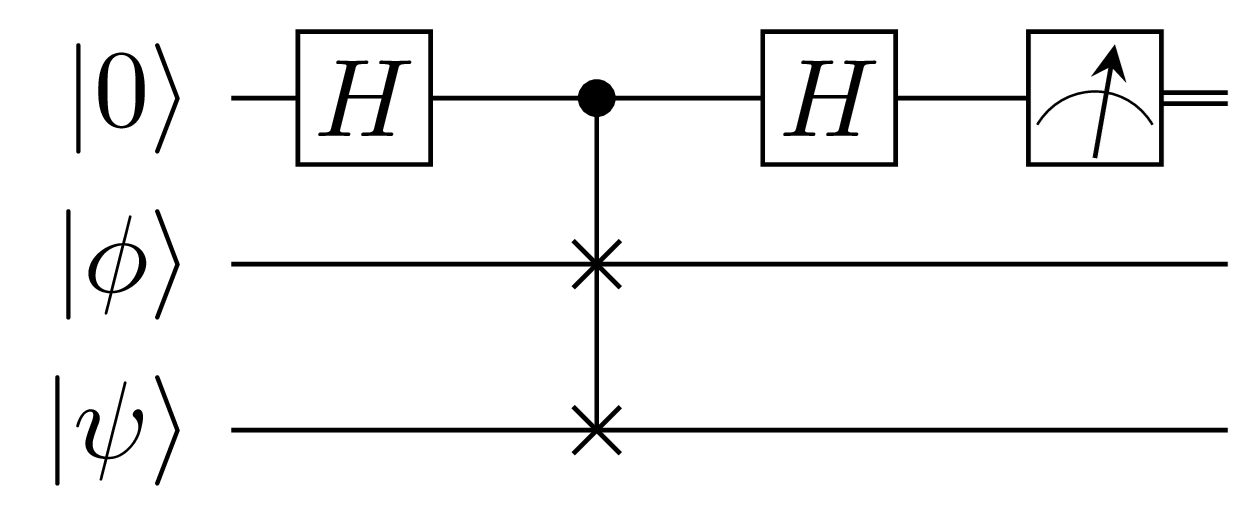

When mesauring the first qubit, we therefore expect to get:
- 0 with probability 1, if the states are identical (up to a global phase)
- 0 and 1 with probability 1/2 each, if the states are orthogonal

Let us check this with identical states and a noiseless emulator.

In [5]:
# Compute amplitudes for a random 3-qubit state

np.random.seed(12)

NUM_QUBITS = 3
amps1 = 1 - 2 * np.random.rand(
    2**NUM_QUBITS
)  # vector of 2^3 random numbers in the range [-1,1]
amps1 = amps1 / np.linalg.norm(amps1)  # normalize the vector
amps2 = amps1  # we're testing identical states

In [6]:
# Write the main function preparing the states from their amplitudes, then performing the swap test on them


@qfunc
def main(test: Output[QBit]):

    state1 = QArray()
    state2 = QArray()
    prepare_amplitudes(amps1.tolist(), 0.0, state1)
    prepare_amplitudes(amps2.tolist(), 0.0, state2)
    swap_test(state1, state2, test)

In [7]:
# Create the model, synthesize and show the circuit


qmod = create_model(main)
qmod = set_execution_preferences(
    qmod, execution_preferences=ExecutionPreferences(num_shots=10_000)
)
qprog = synthesize(qmod)

show(qprog)

Opening: https://platform.classiq.io/circuit/2v4oriRVHjxuxzy19IUGgWXH85b?login=True&version=0.73.0


In [8]:
# Execute quantum program
res = execute(qprog).result()

In [9]:
# Read results
print(res[0].value.parsed_counts)

[{'test': 0}: 10000]


We can see that all our shots yield 1: the circuit is working as expected.

### The quality metric

Moving forward, we will use the same model and synthesize it for noisy hardware. This means we'll get imperfect results and will need a quality metric.

We choose to go for the circuit's error rate as the quality metric, i.e. the share of results which are not 0. A 0.0 error rate means a perfect result, while bad results can in theory go all the way up to 1.0.

Note that this choice is a good fit for cat qubits, since a cat qubit decoheres to a statistical mixture of 0 and 1. It would however not be a good metric for transmon-based architectures, which tend to decohere to 0 and will naturally have a low share of 1 in their results. In this case, using orthogonal states rather than identical states is probably a better idea.

In [10]:
def results_error_rate(res):
    return 1 - res[0].value.counts["0"] / sum(res[0].value.counts.values())

Let us check the quality of the noiseless emulation:

In [11]:
results_error_rate(res)

0.0

As expected, the noiseless emulation has perfect quality.

### The Swap Test on noisy logical qubits

Let us now work with logical qubits.

First, let us remember that a logical qubit, while error-corrected, isn't error-free:
- Not all errors are caught by error correction
- The error correction process itself may introduce errors

Several parameters strongly affect the quality of a logical qubit and it is important to study how they affect your algorithm's results. This lets you better understand the specs of the hardware you will need to get reliable results.

Today, we will be looking at three main parameters:
- The error correction code's distance, `distance`
- The cat qubit's quality, defined by `kappa_1` and `kappa_2`
- The number of photons in the cat qubit, `average_nb_photons`

The first parameter, `distance`, roughly translates into how many physical qubits are used to perform error correction. A higher distance is supposed to bring stronger protection against errors, but also requires a bigger chip with more physical qubits. Two important notes:
- A higher distance only yields fewer errors if your qubits are good "enough", i.e. their error rate is below the error correction threshold. Above the threshold, increasing distance actually increases errors!
- In the specific case of cat qubits, the error correction code is only targeting phase-flip errors. This means that a higher distance actually increases the probability of getting bit-flips. Since the increase is only linear and cat qubits have a strong protection against bit-flips to begin with, the consequences are limited, but they will be visible in our study.

The cat qubit quality parameters `kappa_1` and `kappa_2` can be defined as such:
- `kappa_1` is the rate at which the cat qubit loses a single photon and produces phase-flip errors
- `kappa_2` is the rate at which the cat qubit exchanges two photons with the environement and is stabilized

Given this, one wants `kappa_1` to be small and `kappa_2` to be high. We will therefore look at the `kappa_2/kappa_1` ratio as a proxy for our qubits quality. The higher `kappa_2/kappa_1`, the better the cat qubit.

Finally, `average_nb_photons` is the number of photons in the cat qubit. As it increases, bit-flip errors decrease exponentially and phase-flip errors increase linearly.

Let us now create a custom backend.

You may pick from two preset backends:
- `AliceBobBackendNames.LOGICAL_EARLY`, which has somewhat high logical error rates (1e-3 to 1e-4)
- `AliceBobBackendNames.LOGICAL_TARGET`, which has logical error rates low enough to run Shor's algorithm on a 2048-bit number (~1e-15)

These backends can both be customized and this is what we'll do here. We'll start from `LOGICAL_TARGET` and tune it to make it terrible at phase-flips.
- The `kappa_2/kappa_1` ratio is set to 10, the minimum allowed by the backend. It is below the error correction threshold (which is somewhere around 1e3). This will generate a lot of phase-flips.
- `distance` is set to 31; it is expected that real logical qubits will not use distances this large. Because we made our qubits under threshold, this will further decrease the performance of our logical qubits.
- `average_nb_photons` is set to 19, which means excellent bit-flip error rates but also low phase-flip performance.

In [12]:
backend_preferences = AliceBobBackendPreferences(
    backend_service_provider=ProviderVendor.ALICE_AND_BOB,
    backend_name=AliceBobBackendNames.LOGICAL_TARGET,
    kappa_1=100,
    kappa_2=1e4,
    distance=31,
    average_nb_photons=19,
)
execution_preferences = ExecutionPreferences(
    num_shots=10_000,
    backend_preferences=backend_preferences,
)

# Prepare for HW aware synthesis
preferences = Preferences(
    backend_service_provider=ProviderVendor.ALICE_AND_BOB,
    backend_name=AliceBobBackendNames.LOGICAL_TARGET,
)

# Create Model, set settings and perform HW aware synthesis
model = create_model(main)
model = set_execution_preferences(model, execution_preferences)
model = set_preferences(model, preferences=preferences)
qprog = synthesize(model)

# Execute Quantum Program and show results
res = execute(qprog).result()
print(res[0].value.parsed_counts)

show(qprog)

[{'test': 0}: 5013, {'test': 1}: 4987]
Opening: https://platform.classiq.io/circuit/2v4p14CkjQTcfAiQHEXpospBfE6?login=True&version=0.73.0


As you can see, while the expected output was 0 with probability 1, we've managed to make our backend output pure noise. A logical qubit doesn't always mean a good qubit!

But then, how should we tune our logical qubit to get good results? Let us sweep our parameters to find out.

In [13]:
distances = [x for x in range(3, 16) if x % 2 != 0]
ratios = [10**x for x in range(5, 8)]
nb_photons = [4, 7, 10, 15, 19]

In [14]:
def compute_distance(nb_photons, d, k2, k1=100, sk=2):
    backend_preferences = AliceBobBackendPreferences(
        backend_service_provider=ProviderVendor.ALICE_AND_BOB,
        backend_name=AliceBobBackendNames.LOGICAL_TARGET,
        kappa_1=k1,
        kappa_2=k2,
        distance=d,
        average_nb_photons=nb_photons,
        solovay_kitaev_max_iterations=sk,
    )
    execution_preferences = ExecutionPreferences(
        num_shots=10_000,
        backend_preferences=backend_preferences,
    )

    # Prepare for HW aware synthesis
    preferences = Preferences(
        backend_service_provider=ProviderVendor.ALICE_AND_BOB,
        backend_name=AliceBobBackendNames.LOGICAL_TARGET,
    )

    start = time.time()

    # Create Model, set settings and perform HW aware synthesis
    model = create_model(main)
    model = set_execution_preferences(model, execution_preferences)
    model = set_preferences(model, preferences=preferences)
    qprog = synthesize(model)

    # Execute Quantum Program
    res = execute(qprog).result()

    end = time.time()

    # show(qprog)

    error_rate = results_error_rate(res)

    print("-------------------------------------")
    print(
        "Error rate for nb_photons = %i, distance = %i, k1 = %i, k2 = %i: %f. Time elasped: %f seconds."
        % (nb_photons, d, k1, k2, error_rate, end - start)
    )
    print("-------------------------------------")

    return error_rate

In [15]:
difference = np.zeros((len(nb_photons), len(distances), len(ratios)))
for n in range(len(nb_photons)):
    for i in range(len(distances)):
        for j in range(len(ratios)):
            difference[n, i, j] = compute_distance(
                nb_photons=nb_photons[n], d=distances[i], k2=ratios[j]
            )
            # The line above is very slow - use the line below instead when debugging
            # difference[n, i, j] = np.random.rand(1)

-------------------------------------
Error rate for nb_photons = 4, distance = 3, k1 = 100, k2 = 100000: 0.497000. Time elasped: 71.169343 seconds.
-------------------------------------
-------------------------------------
Error rate for nb_photons = 4, distance = 3, k1 = 100, k2 = 1000000: 0.499800. Time elasped: 96.857939 seconds.
-------------------------------------
-------------------------------------
Error rate for nb_photons = 4, distance = 3, k1 = 100, k2 = 10000000: 0.502300. Time elasped: 68.482089 seconds.
-------------------------------------
-------------------------------------
Error rate for nb_photons = 4, distance = 5, k1 = 100, k2 = 100000: 0.499200. Time elasped: 75.164038 seconds.
-------------------------------------
-------------------------------------
Error rate for nb_photons = 4, distance = 5, k1 = 100, k2 = 1000000: 0.508200. Time elasped: 70.321209 seconds.
-------------------------------------
-------------------------------------
Error rate for nb_photo

In [16]:
def plot_results(ratios, distances, difference, n):
    # Create the meshgrid
    ratios_mesh, distances_mesh = np.meshgrid(ratios, distances)
    ratios_mesh_log = np.log10(ratios_mesh)

    # Define the colormap
    colors = [(0, 0.5, 0), (0.9, 0.5, 0), (0.9, 0, 0)]
    n_bins = 100  # Discretizes the interpolation into bins
    cmap_name = "red_darker_green"
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        ratios_mesh_log,
        distances_mesh,
        difference[n, :, :],
        shading="auto",
        cmap=cmap,
        vmin=0.0,
        vmax=0.5,
    )
    plt.xticks(
        np.log10(ratios), labels=[f"$10^{int(np.log10(r/100))}$" for r in ratios]
    )
    plt.yticks(distances)

    # Adding the value on each pixel
    for i in range(len(distances)):
        for j in range(len(ratios)):
            plt.text(
                np.log10(ratios[j]),
                distances[i],
                f"{difference[n, i, j]:.3f}",
                ha="center",
                va="center",
                color="white",
            )

    plt.colorbar(label="Circuit error rate")
    plt.xlabel("$\kappa_2/\kappa_1$")
    plt.ylabel("Distances")
    plt.title(f"avg number of photons = {nb_photons[n]}")

    plt.show()

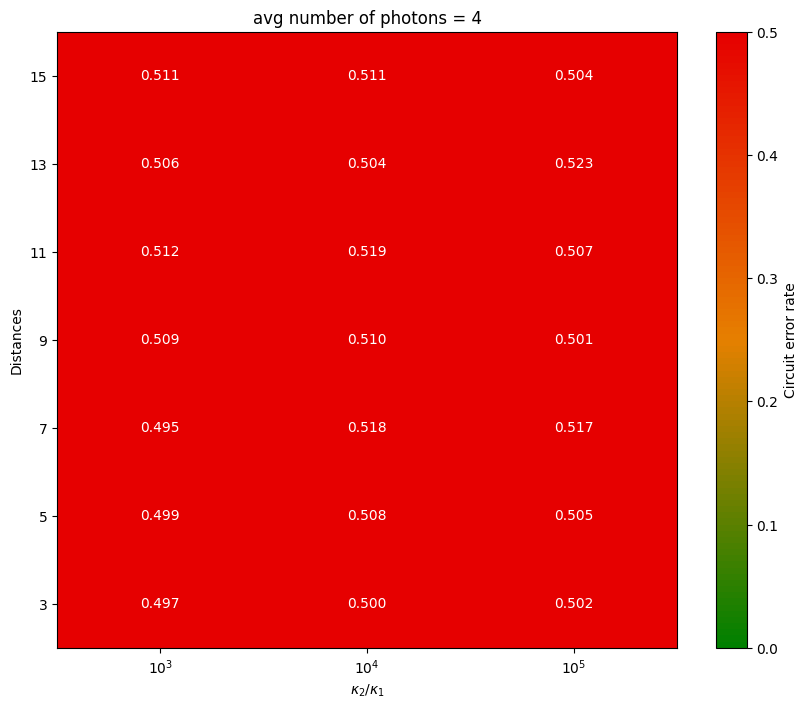

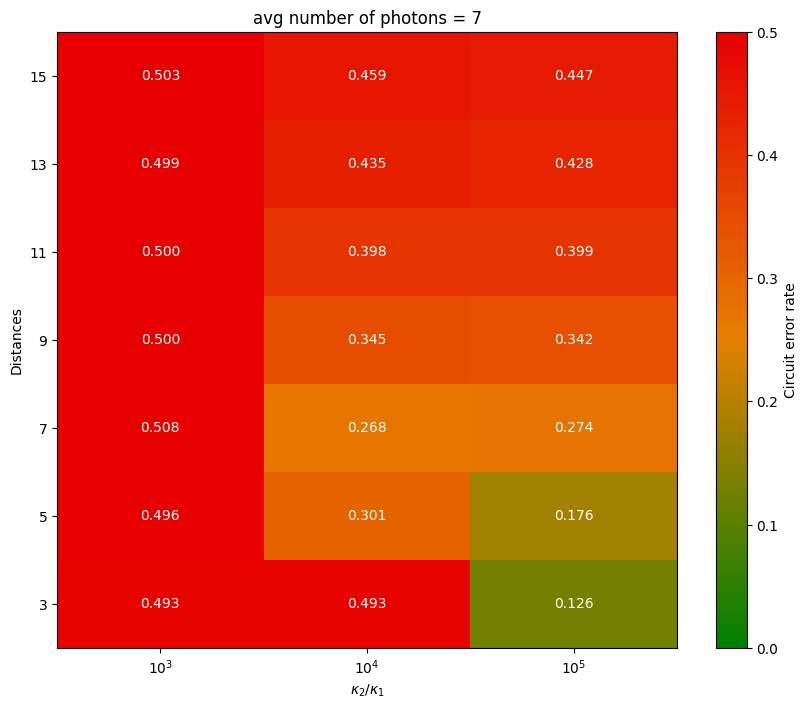

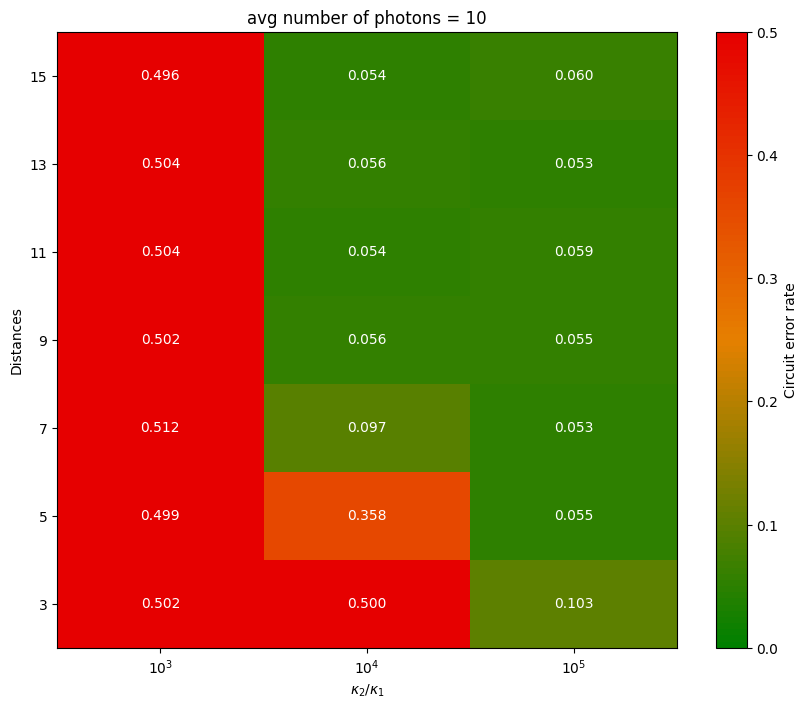

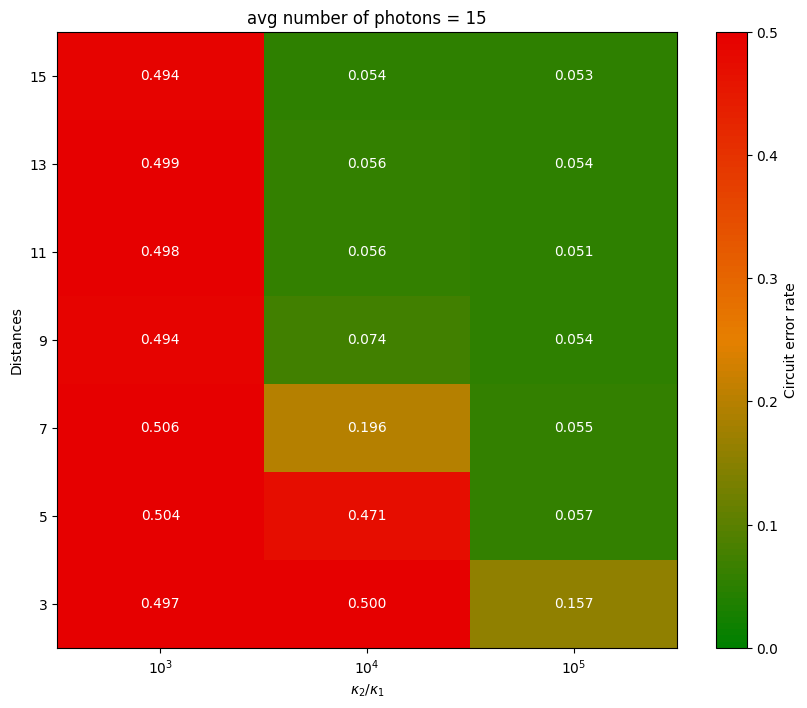

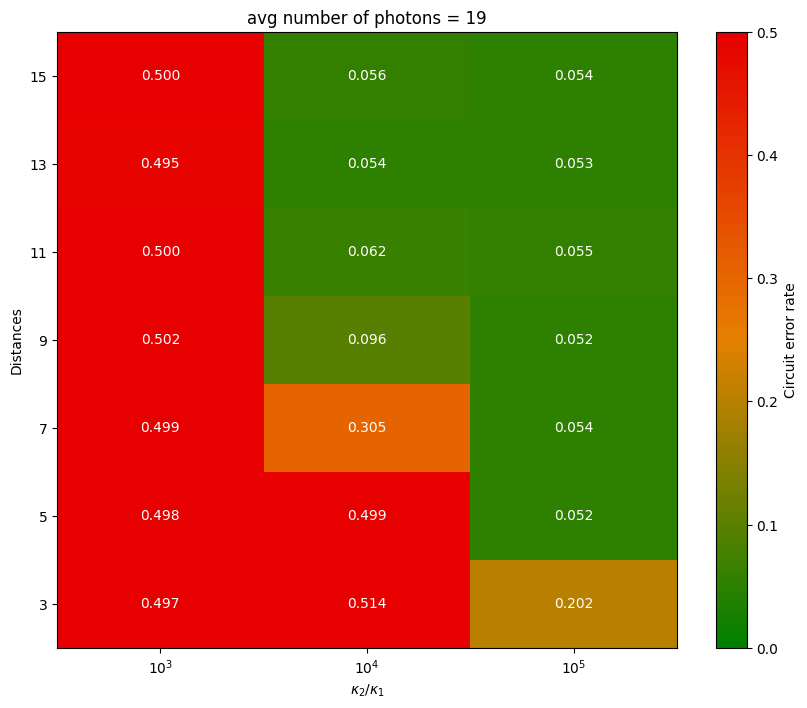

In [17]:
for n in range(len(nb_photons)):
    plot_results(ratios, distances, difference, n)

These results deserve some comments.

We are looking at the impact of three parameters here:
- Qubit quality ($\kappa_2/\kappa_1$)
- Number of photons in the cat qubit (`average_nb_photons`)
- Code distance (`distance`)

The impact of qubit quality is as you would expect: when the other two parameters are fixed, improving qubit quality always improves the results.

There is however a clear threshold somewhere between $\kappa_2/\kappa_1 = 10^3$ and $\kappa_2/\kappa_1 = 10^4$. This threshold corresponds to the repetition code's threshold: when physical qubits aren't good enough, error correction adds errors and makes results unusable.

As for the number of photons, there is also some threshold, although this one depends on the specific circuit you're running. Here, we see that at 4 photons, the bit-flip performance is simply too low for the results to be usable, no matter what the other two settings are.

No amount of error correction can fix this - if anything, it makes things worse because increasing distance further decreases bit-flip performance. Remember, while the repetition code used by cat qubits exponentially removes phase-flips, it also linearly increases bit-flips. This is why you want the bit-flip performance to be excellent to begin with, meaning you want to use a fairly high number of photons.

At 7 photons and $\kappa_2/\kappa_1 = 10^4$, an interesting phenomenon can be witnessed: results get better as distance increases from 3 to 7, but further increasing the distance actually makes them worse. This is because as distance increases, the dominant source of error changes: up to distance 7, phase-flips are the limiting factor, so increasing distance improves the results. But beyond distance 7, bit-flips start to become the limiting factor and it only gets worse as you further increase the distance.

This analysis shows us that in order to run an algorithm on logical qubits, there is a sweet spot to be found. For a given chip (with a fixed $\kappa_2/\kappa_1$ ratio), you'll need to find the right combination of distance and number of photons.

While the number of photons is easy to change, it is still unclear to what extent a real chip will let you pick different code distances. If architectures aren't modular enough, then different chips implementing different distances might be needed for different applications. One thing is for sure though: a longer distance means a higher number of qubits and slower operations, so you'll always want to favor the regime requiring the shortest possible distance.

## Conclusion

We hope this notebook gave you a clearer view of some of the challenges involved in using logical qubits.

You may now reuse the principles showcased in this notebook to study the behavior of your own algorithms on logical backends, and discover what specs and settings will be required to obtain reliable results.

The principles of this notebook are however limited to circuits which can be classically emulated. If you wish to study what happens with bigger circuits, beyond the capability of current emulators, then you'll need to switch to a different approach: resource estimation.

Resource estimation computes how many qubits and how much time will be required to run a given circuit, but without actually running the circuit. You may check out the Microsoft Resource Estimator at https://learn.microsoft.com/en-us/azure/quantum/intro-to-resource-estimation, or Alice & Bob's variant, specifically adapted to cat qubits, at https://github.com/Alice-Bob-SW/qsharp-alice-bob-resource-estimator.